In [3]:
!pip install transformers datasets umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [4]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(model_ckpt).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
 def tokenize(batch):
     return tokenizer(batch["text"], padding=True, truncation=True)

In [7]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
import torch

def extract_hidden_states(batch, model, tokenizer, device):
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [9]:
 emotions_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])

In [10]:
emotions_hidden = emotions_encoded.map(lambda batch: extract_hidden_states(batch, model, tokenizer, device), batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [11]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [12]:
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [13]:
import pandas as pd
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.186001,6.618032,0
1,-3.186208,5.421739,0
2,5.138589,3.244008,3
3,-2.537905,3.302323,2
4,-3.370489,3.523022,3


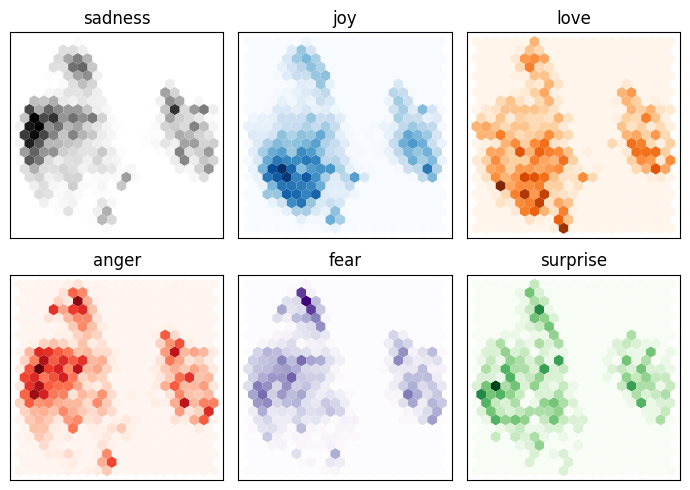

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")  # Assuming df_emb is defined elsewhere
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=0)
    axes[i].set_title(label)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()


In [15]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.635

In [16]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [17]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification
.from_pretrained(model_ckpt, num_labels=num_labels)
.to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [21]:
from transformers import Trainer, TrainingArguments
batch_size = 64

logging_steps = len(emotions_encoded["train"]) // batch_size

model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                     num_train_epochs=10,
                     learning_rate=2e-5,
                     per_device_train_batch_size=batch_size,
                     per_device_eval_batch_size=batch_size,
                     weight_decay=0.01,
                     evaluation_strategy="epoch",
                     disable_tqdm=False,
                     logging_steps=logging_steps,
                     log_level="error")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
from transformers import Trainer

trainer = Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=emotions_encoded["train"],
                    eval_dataset=emotions_encoded["validation"],
                    tokenizer=tokenizer)

trainer.train();

<ipython-input-22-64b5b614e253>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.178100,0.171567,0.933000,0.933617
2,0.124600,0.165144,0.933500,0.934264
3,0.103500,0.154986,0.939000,0.939797
4,0.082600,0.158616,0.939000,0.938969
5,0.067400,0.169292,0.932000,0.932049
6,0.053800,0.163775,0.944000,0.944372
7,0.044300,0.203968,0.933000,0.932652
8,0.035400,0.195781,0.933000,0.933121
9,0.028700,0.202627,0.935000,0.935174
10,0.023800,0.204125,0.935500,0.935624


In [23]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [24]:
y_preds = np.argmax(preds_output.predictions, axis=1)

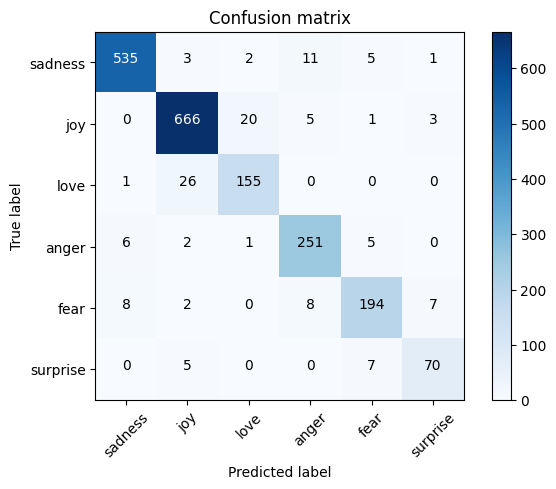

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
plot_confusion_matrix(y_preds, y_valid, labels)

In [26]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }

In [27]:
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])

In [28]:
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

SAD - sadness;

ANG - angry;

DIS - disgust;

FEA - fear;

HAP - happy;

NEU - neutral.

emotion_labels = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}

In [29]:
def label_int2str(label_int):
    label_map = {0: "sadness", 1: "joy", 2: "love", 3: "anger",4:"fear",5:"surprise"}
    return label_map[label_int]

In [30]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
.apply(label_int2str))

In [31]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,10.218118
1195,i always think about are act the way i want to...,anger,joy,7.987915
1801,i feel that he was being overshadowed by the s...,love,sadness,7.485557
1919,i should admit when consuming alcohol myself i...,fear,sadness,7.456393
1111,im lazy my characters fall into categories of ...,joy,fear,7.306053
1096,i feel god calling me there and if he wills it...,love,joy,7.218326
1870,i guess i feel betrayed because i admired him ...,joy,love,7.050749
882,i feel badly about reneging on my commitment t...,love,sadness,6.920854
1757,i feel like there s a reason to buy another to...,anger,joy,6.518802
1963,i called myself pro life and voted for perry w...,joy,anger,6.422410


In [32]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1455,i have had i feel like there is not too much i...,joy,joy,0.000175
1425,i see you the light in the room brightens i ge...,joy,joy,0.000176
1136,i feel cheated and at another i feel ashamed t...,sadness,sadness,0.000182
264,i am left feeling underwhelmed and ungrateful,sadness,sadness,0.000184
491,i feel like it is a valuable addition to any t...,joy,joy,0.000184
213,i didnt regret anything after bought this and ...,joy,joy,0.000185
861,i am feeling awfully lonely today and i dont w...,sadness,sadness,0.000186
1089,i could think was i wonder how many days i hav...,sadness,sadness,0.000186
968,i have that feeling most days of the week im s...,joy,joy,0.000187
533,i think about them tomorrow tomorrow but right...,sadness,sadness,0.000187


In [34]:
import joblib
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_save_dir = "trnsformer"

model.save_pretrained(model_save_dir)
tokenizer.save_pretrained(model_save_dir)

joblib.dump(MinMaxScaler(), f"{model_save_dir}/minmax_scaler.pkl")
joblib.dump(mapper, f"{model_save_dir}/umap_model.pkl")

model.config.save_pretrained(model_save_dir)

trainer.save_model(model_save_dir)
trainer.state.save_to_json(f"{model_save_dir}/trainer_state.json")

print(f"All necessary files are saved in {model_save_dir}")

All necessary files are saved in trnsformer


In [35]:
!zip -r /content/transformer.zip /content/trnsformer

  adding: content/trnsformer/ (stored 0%)
  adding: content/trnsformer/model.safetensors (deflated 8%)
  adding: content/trnsformer/vocab.txt (deflated 53%)
  adding: content/trnsformer/special_tokens_map.json (deflated 42%)
  adding: content/trnsformer/training_args.bin (deflated 51%)
  adding: content/trnsformer/tokenizer_config.json (deflated 75%)
  adding: content/trnsformer/trainer_state.json (deflated 76%)
  adding: content/trnsformer/minmax_scaler.pkl (deflated 5%)
  adding: content/trnsformer/tokenizer.json (deflated 71%)
  adding: content/trnsformer/config.json (deflated 52%)
  adding: content/trnsformer/umap_model.pkl (deflated 21%)
